# OS Motifs

Plot for motifs recovered from high OSK model in transient early peaks. 

Another to compare OCT-SOX motifs between transient peaks from neural-like state and those from iPSC models.

**Inputs**:
1. Output directory of `high_OSK_vs_iPSC_modisco.ipynb`. It should contain aggregate PWM and CWM for OCT-SOX motif for both high OSK and iPSC states, and subcluster PWMs with their associated counts. Ordered in decreasing counts. And appropriate orientation.

In [1]:
library(ggseqlogo)
library(ggplot2)
library(patchwork)

## Loading Inputs

In [8]:
read_nptxt_matrix <- function(fname) {
    d=read.table(fname)
    colnames(d) = c("A", "C", "G", "T")
    t(d)
}

In [10]:
high_OSK_pwm = read_nptxt_matrix("./OS_motif_intermediate/high_OSK/agg_PWM.txt")
high_OSK_cwm = read_nptxt_matrix("./OS_motif_intermediate/high_OSK/agg_CWM.txt")
ipsc_pwm = read_nptxt_matrix("./OS_motif_intermediate/iPSC/agg_PWM.txt")
ipsc_cwm = read_nptxt_matrix("./OS_motif_intermediate/iPSC/agg_CWM.txt")

In [14]:
high_OSK_subcluster_cts = read.table("./OS_motif_intermediate/high_OSK/subcluster_counts.txt")
ipsc_subcluster_cts = read.table("./OS_motif_intermediate/iPSC/subcluster_counts.txt")

high_OSK_subcluster_cts
ipsc_subcluster_cts

V1,V2
<int>,<int>
0,2115
1,1648
2,1638
3,1519
4,1386
5,506
6,215
7,210
8,146


V1,V2
<int>,<int>
0,796
1,602
2,444
3,363
4,296
5,220


## Plot

In [22]:
revcomp <- function(x) {
    x = x[rev(seq(nrow(x))), rev(seq(ncol(x)))]
    rownames(x) = c("A", "C", "G", "T")
    x
}

In [16]:
trim_and_plot <- function(m, rc=F, trim_left=0, trim_right=0, method='bits', ymin=0, ymax=2, title=NULL) {
    if (rc) {
        m = revcomp(m)                
    }

    m = m[, trim_left:(ncol(m)-trim_right)]

    rownames(m) = c("A","C","G","T")
    
    p <- ggseqlogo(m, method=method, ncol=1) + 
                                    ylim(c(ymin,ymax)) +
                                    theme_void() 
    
    if (!is.null(title)) {
        p = p + ggtitle(title)
        p = p + theme(plot.title = element_text(hjust = 0.5, size=18))
    }
    
    p
}

In [28]:
high_OSK_subcluster_cts[2,2]

[1] 1648

In [75]:
get_plots <- function(pwm, cwm, subcluster_cts, subcluster_base_path, rc=F, trim_left=0, trim_right=0, first_yaxis=F) {
    transient_plots = list()
    tot_instances = sum(subcluster_cts[,2])
    
    # PWM -> IC content
    transient_plots[[1]] = trim_and_plot(pwm,
                                         rc, trim_left, trim_right
                                        )
    
    # CWM -> raw numbers
    transient_plots[[2]] = trim_and_plot(cwm,
                                         rc, trim_left, trim_right, method='custom',
                                         ymin=min(cwm)-0.01, ymax=max(cwm)+0.01
                                        )
    
    transient_plots[[3]] = ggplot() + theme_void() + annotate("segment", x=0, xend=1, y=0, yend=0)

    
    i = 4
    
    num_instances_per_motif = c()
    for (x in seq(nrow(subcluster_cts))) {

        submotif = read_nptxt_matrix(sprintf(subcluster_base_path, subcluster_cts[x,1]))
        num_instances = subcluster_cts[x,2]

        if (num_instances/tot_instances > 0.05) {
            num_instances_per_motif= c(num_instances_per_motif, num_instances)


            transient_plots[[i]] = trim_and_plot(submotif, rc, trim_left, trim_right)

            transient_plots[[i]] = transient_plots[[i]] +
                                    annotate('text', 
                                             x=ncol(submotif)-trim_left-trim_right-1, 
                                             y=1.8, 
                                             size=7, 
                                             label=sprintf("%.2f", 100*(num_instances/tot_instances))) +
                                    annotate('text', 
                                            x=1.5,
                                            y=1.8,
                                             size=5,
                                            label=as.character(i-3)) +

            theme(plot.margin = unit(c(20,0,0,0), "pt"))

            if ((i==4) &&(first_yaxis)) {
                transient_plots[[i]] = transient_plots[[i]] + 
                theme_void() +
                scale_y_continuous(limits=c(0,2),
                                   breaks=c(0,1,2))  +
                theme(axis.title.y = element_blank(),
                      axis.text.y = element_text(margin = margin(0,5,0,0)),
                     axis.ticks.y = element_line(size=1,  linetype = "solid"),
                     axis.text.x = element_blank(),
                     axis.ticks.x = element_blank())
        }

        i = i +1
        }
        
    }    
    
    # sort by num instances
    reordered_plots = list()
    for (i in seq(3)) {
        reordered_plots[[i]] = transient_plots[[i]]
    }
    
    i = 4
    for (x in rev(order(num_instances_per_motif))) {
        reordered_plots[[i]] = transient_plots[[x+3]]
        i = i +1
    }
    
    reordered_plots

}

In [76]:
high_OSK_plots = get_plots(high_OSK_pwm, high_OSK_cwm, high_OSK_subcluster_cts, "./OS_motif_intermediate/high_OSK/subcluster_%d_pwm.txt", 
                           rc=F, trim_left=0, trim_right=0, first_yaxis = T)

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



In [77]:
ipsc_plots = get_plots(ipsc_pwm, ipsc_cwm, ipsc_subcluster_cts, "./OS_motif_intermediate/iPSC/subcluster_%d_pwm.txt",
                       rc=F, trim_left=0, trim_right=0, first_yaxis = F)

In [78]:
consolidated_plots = list()

for (i in seq(max(length(ipsc_plots), length(high_OSK_plots)))) {
    left_plot = plot_spacer()
    right_plot = plot_spacer()
    
    if (i<=length(high_OSK_plots)) {
        left_plot = high_OSK_plots[[i]]
    }
    
    if (i<=length(ipsc_plots)) {
        right_plot = ipsc_plots[[i]]
    }
    
    consolidated_plots[[i]] = wrap_plots(left_plot, plot_spacer(), right_plot, widths=c(1,0,1))
}

In [79]:
TXTSZ=8

In [80]:
top_plot = ggplot() + annotate("text", x=2.5, y=1, label="High OSK", size=TXTSZ) +
            annotate("text", x=7.5, y=1, label="iPSC", size=TXTSZ) +
            xlim(c(0,10)) + 
            theme_void()

In [81]:
left_plot = ggplot() + annotate("text", x=1, y=10, label="PWM", size=TXTSZ) +
            annotate("text", x=1, y=9.1, label="CWM", size=TXTSZ) +
            annotate("text", x=1, y=4.5, label="Subcluster\nPWM", angle=90, size=TXTSZ) +
            ylim(c(0,10)) + 
            theme_void()

In [82]:
pwm_cwm_submotifs <- wrap_plots(top_plot,
                                wrap_plots(left_plot, wrap_plots(consolidated_plots, ncol=1),
                                widths=c(1,9)),
                                heights=c(1,10))

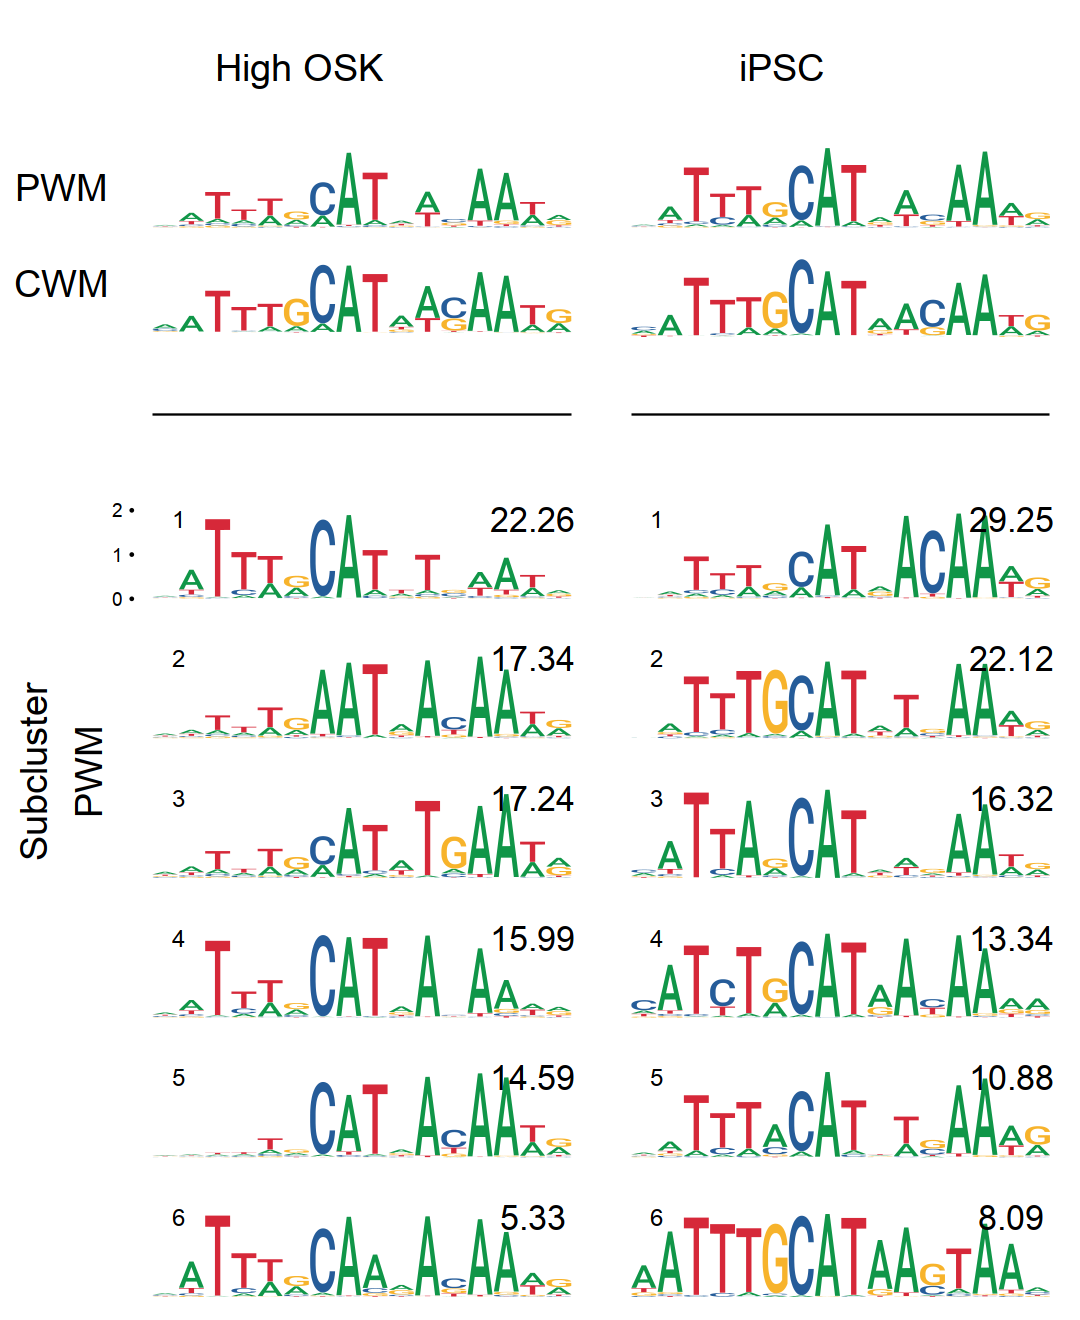

In [83]:
options(repr.plot.width = 9, repr.plot.height = 11)

pwm_cwm_submotifs

In [84]:
ggsave("./subfigs/iPSC_vs_high_OSK_OCTSOX_motifs.pdf", pwm_cwm_submotifs, height=11, width=9, useDingbats=F)

---

In [65]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /users/surag/anaconda3/envs/r36_cran/lib/libopenblasp-r0.3.9.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] patchwork_1.0.0 ggplot2_3.3.3   ggseqlogo_0.1  

loaded via a namespace (and not attached):
 [1] magrittr_1.5      tidyselect_1.1.0  munsell_0.5.0     uuid_0.1-4       
 [5] colorspace_1.4-1  R6_2.4.1          rlang_0.4.11      dplyr_1.0.2      
 [9] tools_3.6.3       grid_3.6.3        gtable_0